In [1]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline

In this tutorial, we show how to use PennyLane to implement variational quantum classifiers - quantum circuits that can be trained from labelled data to classify new data samples. The architecture is inspired by Farhi and Neven (2018) as well as Schuld et al. (2018).

Ref: https://pennylane.ai/qml/demos/tutorial_variational_classifier/

We will first show that the variational quantum classifier can reproduce
the parity function

$$\begin{aligned}
f: x \in \{0,1\}^{\otimes n} \rightarrow y =
\begin{cases} 1 \text{  if uneven number of ones in } x \\ 0
\text{ otherwise} \end{cases}.
\end{aligned}$$

This optimization example demonstrates how to encode binary inputs into
the initial state of the variational circuit, which is simply a
computational basis state.

We then show how to encode real vectors as amplitude vectors (*amplitude
encoding*) and train the model to recognize the first two classes of
flowers in the Iris dataset.

1. Fitting the parity function
==============================

Imports
-------

As before, we import PennyLane, the PennyLane-provided version of NumPy,
and an optimizer.

Please note that we need to import numpy from pennylane, for any reason if you need to import standard numpy, please import as

**from pennylane import numpy as plnp**

**import numpy as np**

workflow for Parity fit function

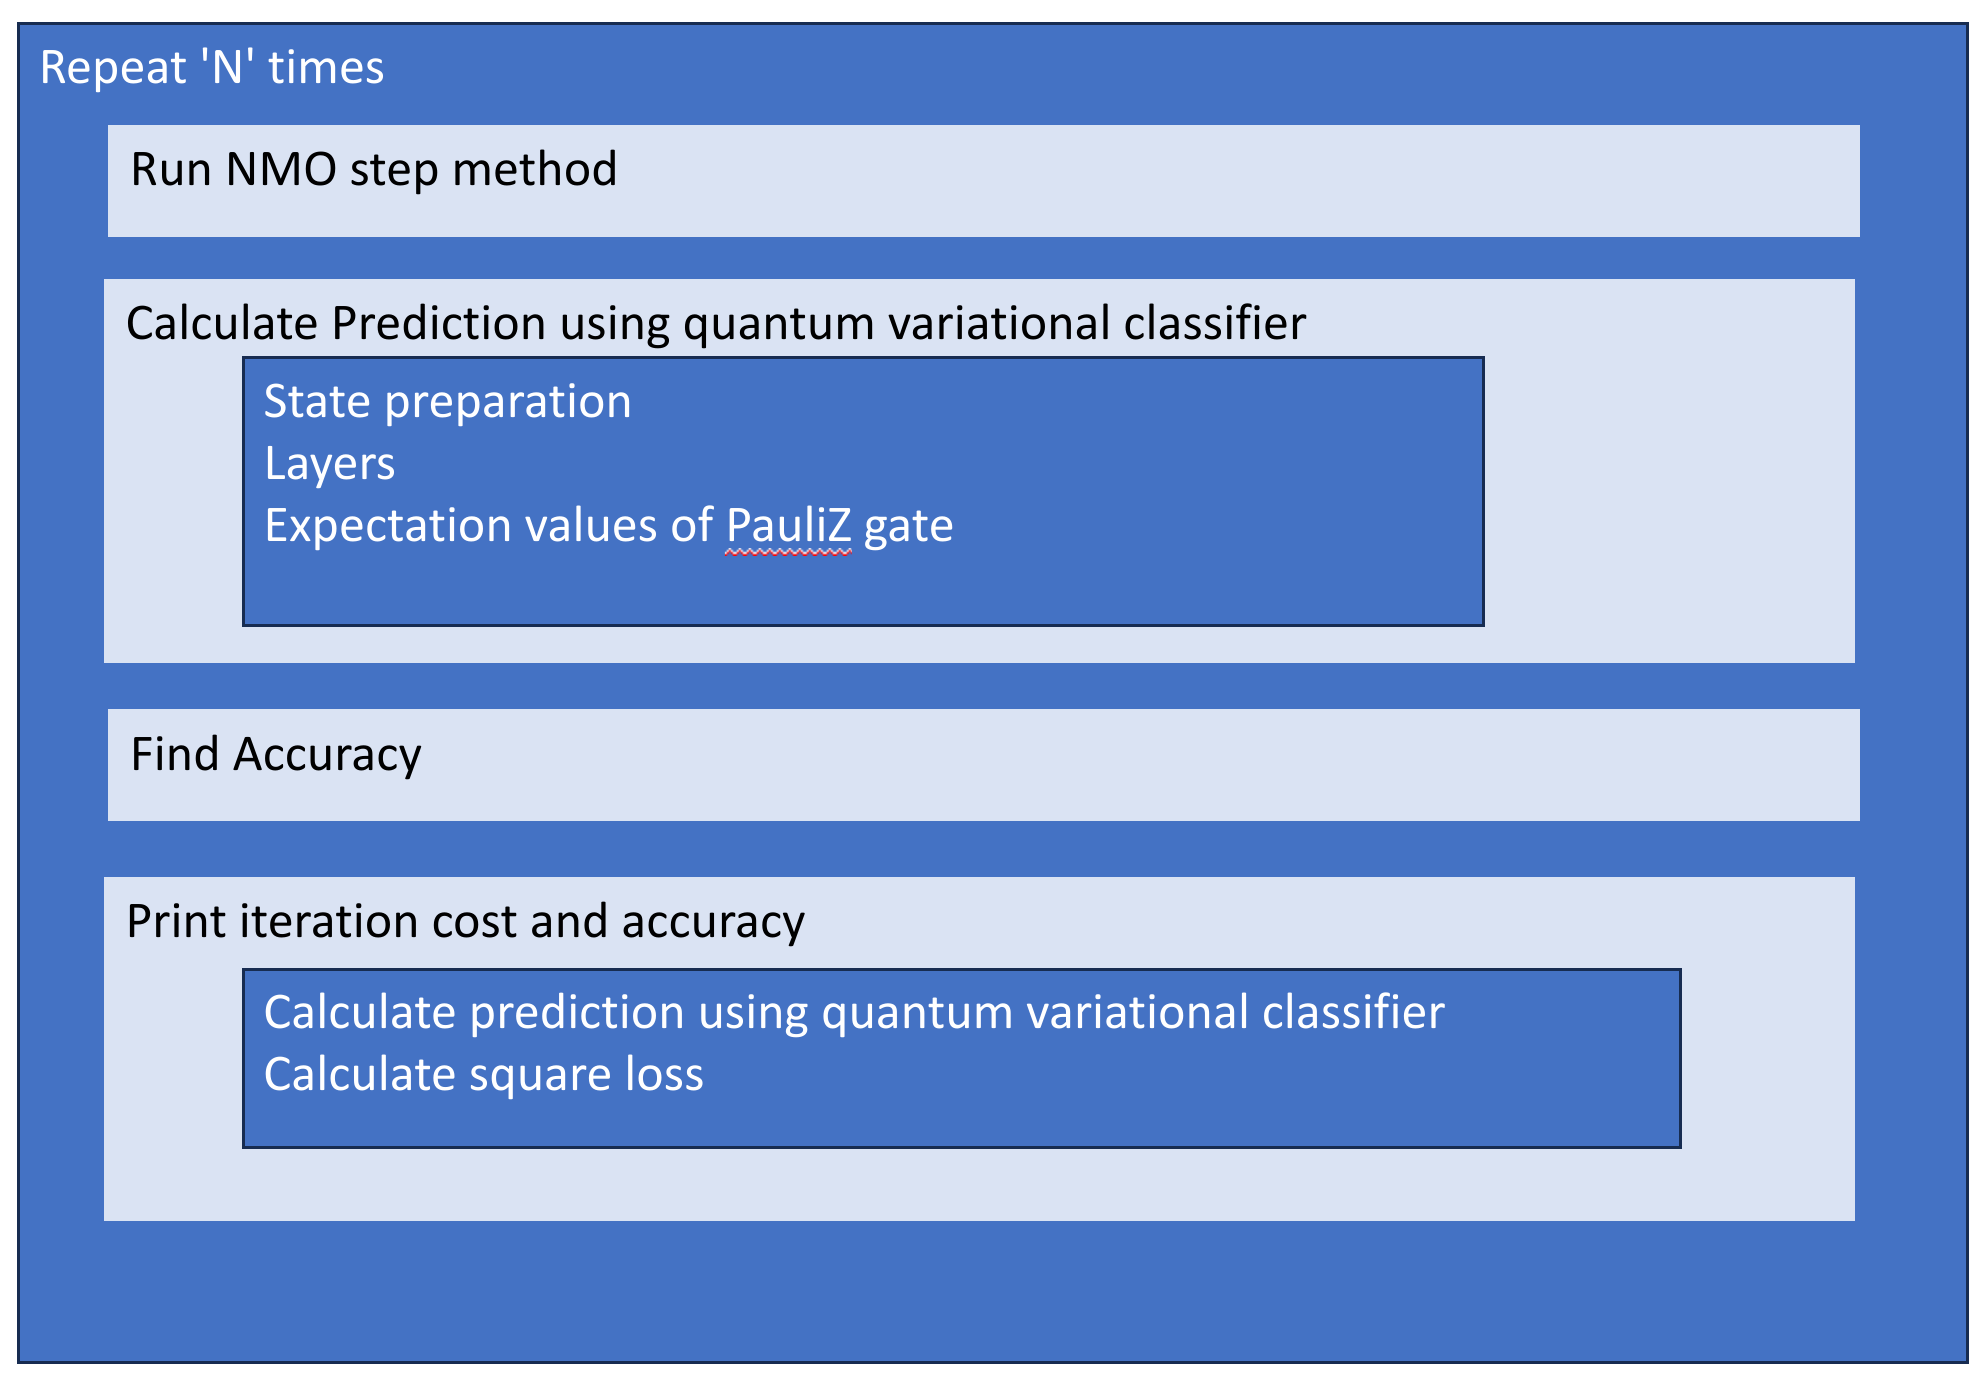

In [2]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer

Quantum and classical nodes
===========================

We create a quantum device with four "wires" (or qubits).  To know more about qml.device, click here 
https://docs.pennylane.ai/en/stable/code/api/pennylane.device.html

How to call AWS devices from qml.device

**dev = qml.device('braket.aws.qubit',device_arn=device_arn, wires=..., shots=...)**


In [3]:

# Quantum simulator/QPU
#dev = qml.device("lightning.qubit", wires=n_qubits)
#dev = qml.device("default.qubit", wires=4)
#n_shots=1000
n_shots=2000
n_qubits=4
#dev = qml.device("lightning.qubit", wires=tot_qubits)
dev = qml.device('braket.aws.qubit', device_arn='arn:aws:braket:eu-west-2::device/qpu/oqc/Lucy', wires=n_qubits, shots=n_shots)
#dev = qml.device('braket.aws.qubit', device_arn='arn:aws:braket:::device/quantum-simulator/amazon/sv1', wires=n_qubits, shots=n_shots)

Variational classifiers usually define a "layer" or "block", which is an
elementary circuit architecture that gets repeated to build the
variational circuit.

Our circuit layer consists of an arbitrary rotation on every qubit, as
well as CNOTs that entangle each qubit with its neighbour.


In [4]:
def layer(W):

    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    qml.Rot(W[2, 0], W[2, 1], W[2, 2], wires=2)
    qml.Rot(W[3, 0], W[3, 1], W[3, 2], wires=3)

    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[2, 3])
    qml.CNOT(wires=[3, 0])

We also need a way to encode data inputs $x$ into the circuit, so that
the measured output depends on the inputs. In this first example, the
inputs are bitstrings, which we encode into the state of the qubits. The
quantum state $\psi$ after state preparation is a computational basis
state that has 1s where $x$ has 1s, for example

$$x = 0101 \rightarrow |\psi \rangle = |0101 \rangle .$$

We use the `~pennylane.BasisState`{.interpreted-text role="class"}
function provided by PennyLane, which expects `x` to be a list of zeros
and ones, i.e. `[0,1,0,1]`.


In [5]:
def statepreparation(x):
    qml.BasisState(x, wires=[0, 1, 2, 3])

Now we define the quantum node as a state preparation routine, followed
by a repetition of the layer structure. Borrowing from machine learning,
we call the parameters `weights`.


In [ ]:
@qml.qnode(dev)
def circuit(weights, x):

    statepreparation(x)

    for W in weights:
        layer(W)

    return qml.expval(qml.PauliZ(0))

Different from previous examples, the quantum node takes the data as a
keyword argument `x` (with the default value `None`). Keyword arguments
of a quantum node are considered as fixed when calculating a gradient;
they are never trained.

If we want to add a "classical" bias parameter, the variational quantum
classifier also needs some post-processing. We define the final model by
a classical node that uses the first variable, and feeds the remainder
into the quantum node. Before this, we reshape the list of remaining
variables for easy use in the quantum node.


In [ ]:
def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias

Cost
====

In supervised learning, the cost function is usually the sum of a loss
function and a regularizer. We use the standard square loss that
measures the distance between target labels and model predictions.


In [ ]:
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

To monitor how many inputs the current classifier predicted correctly,
we also define the accuracy given target labels and model predictions.


In [ ]:
def accuracy(labels, predictions):

    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)

    return loss

For learning tasks, the cost depends on the data - here the features and
labels considered in the iteration of the optimization routine.


In [ ]:
def cost(weights, bias, X, Y):
    predictions = [variational_classifier(weights, bias, x) for x in X]
    return square_loss(Y, predictions)

Optimization
============

Let's now load and preprocess some data.

::: {.note}
::: {.title}
Note
:::

The parity dataset can be downloaded
`<a href="https://raw.githubusercontent.com/XanaduAI/qml/master/demonstrations/variational_classifier/data/parity.txt"
download=parity.txt target="_blank">here</a>`{.interpreted-text
role="html"} and should be placed in the subfolder
`data`.
:::


Here we are reading the parity data and initialize X and Y arrays.

In [ ]:
data = np.loadtxt("data/parity.txt")
X = np.array(data[:, :-1], requires_grad=False)
Y = np.array(data[:, -1], requires_grad=False)
Y = Y * 2 - np.ones(len(Y))  # shift label from {0, 1} to {-1, 1}

for i in range(5):
    print("X = {}, Y = {: d}".format(X[i], int(Y[i])))

print("...")

We initialize the variables randomly (but fix a seed for
reproducibility). The first variable in the list is used as a bias,
while the rest is fed into the gates of the variational circuit.


In [ ]:
np.random.seed(0)
num_qubits = 4
num_layers = 2
weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

print(weights_init, bias_init)

Next we create an optimizer and choose a batch size...

To learn more about NMO Optimizer click here 

https://docs.pennylane.ai/en/stable/code/api/pennylane.NesterovMomentumOptimizer.html

Gradient-descent optimizer with Nesterov momentum.  To learn more about Gradient-decent based optimizers click here https://www.ruder.io/optimizing-gradient-descent/

Nesterov Momentum works like the Momentum optimizer, but shifts the current input by the momentum term when computing the gradient of the objective function:

a(t+1)=ma(t)+η∇f(x(t)−ma(t)).

The user defined parameters are:

η: the step size

m: the momentum
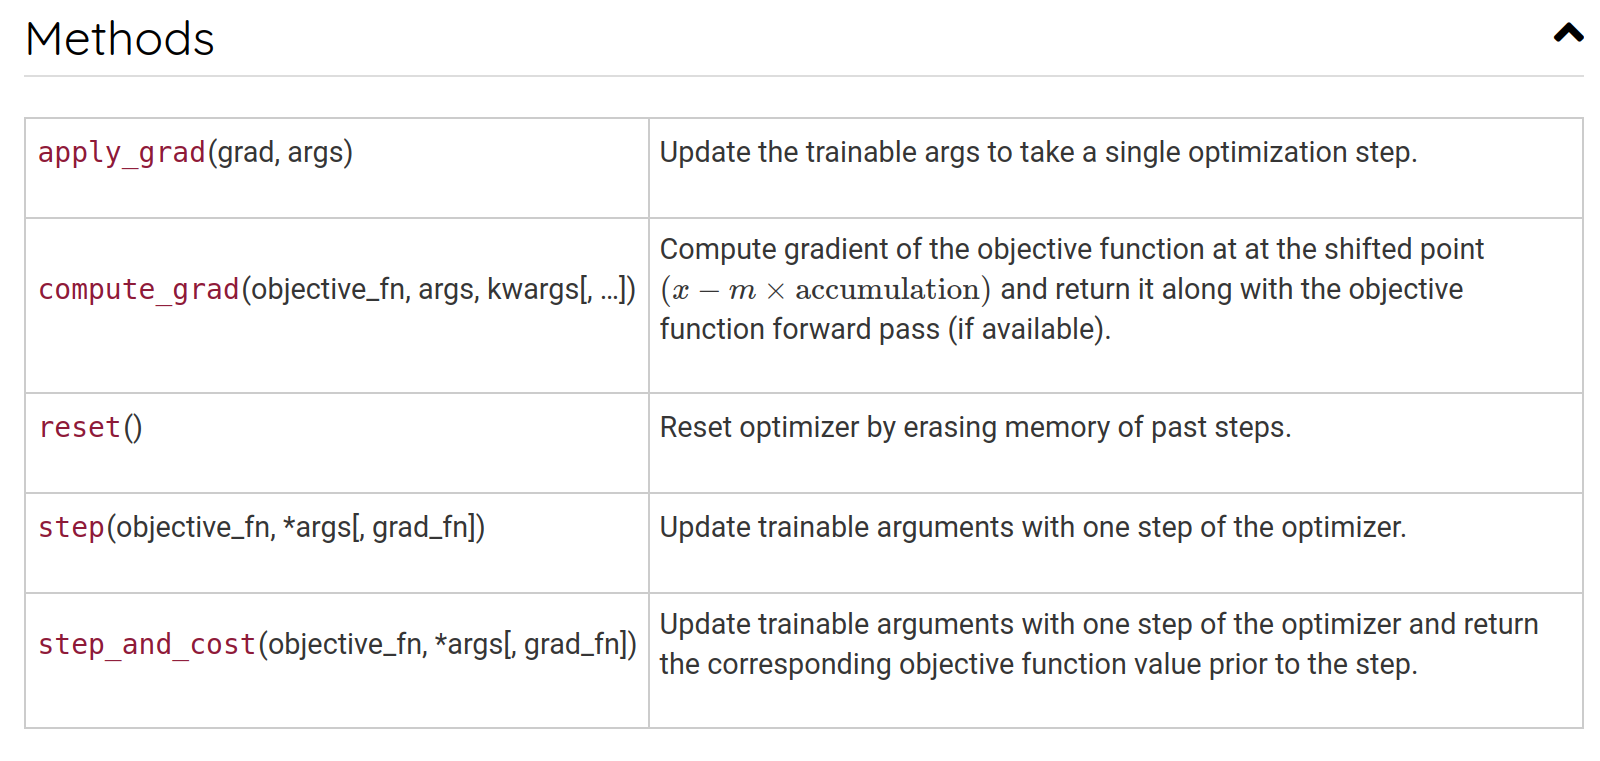


In [ ]:
opt = NesterovMomentumOptimizer(0.5)
batch_size = 5

...and train the optimizer. We track the accuracy - the share of
correctly classified data samples. For this we compute the outputs of
the variational classifier and turn them into predictions in $\{-1,1\}$
by taking the sign of the output.


In [ ]:
weights = weights_init
bias = bias_init
for it in range(25):

    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, len(X), (batch_size,))
    X_batch = X[batch_index]
    Y_batch = Y[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, X_batch, Y_batch)

    # Compute accuracy
    predictions = [np.sign(variational_classifier(weights, bias, x)) for x in X]
    print(predictions)
    acc = accuracy(Y, predictions)

    print(
        "Iter: {:5d} | Cost: {:0.7f} | Accuracy: {:0.7f} ".format(
            it + 1, cost(weights, bias, X, Y), acc
        )
    )

2. Iris classification
======================

Quantum and classical nodes
---------------------------

To encode real-valued vectors into the amplitudes of a quantum state, we
use a 2-qubit simulator.


Introduction to IRIS dataset

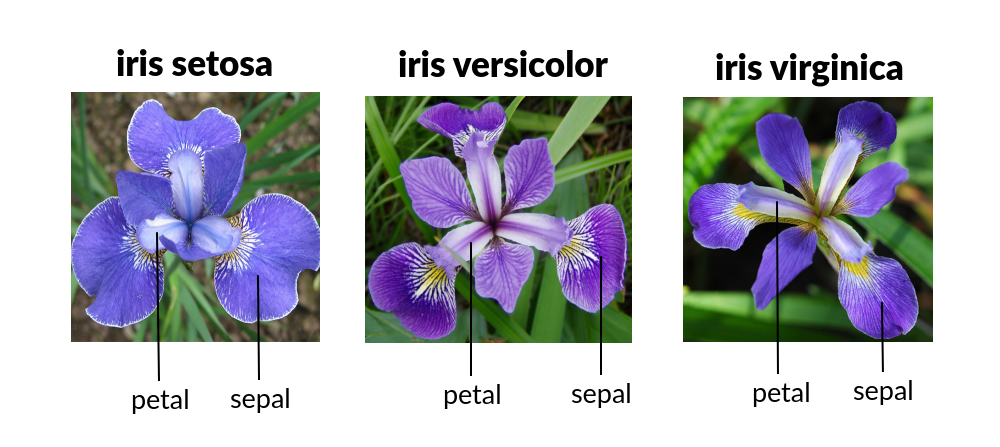

Classification of IRIS dataset
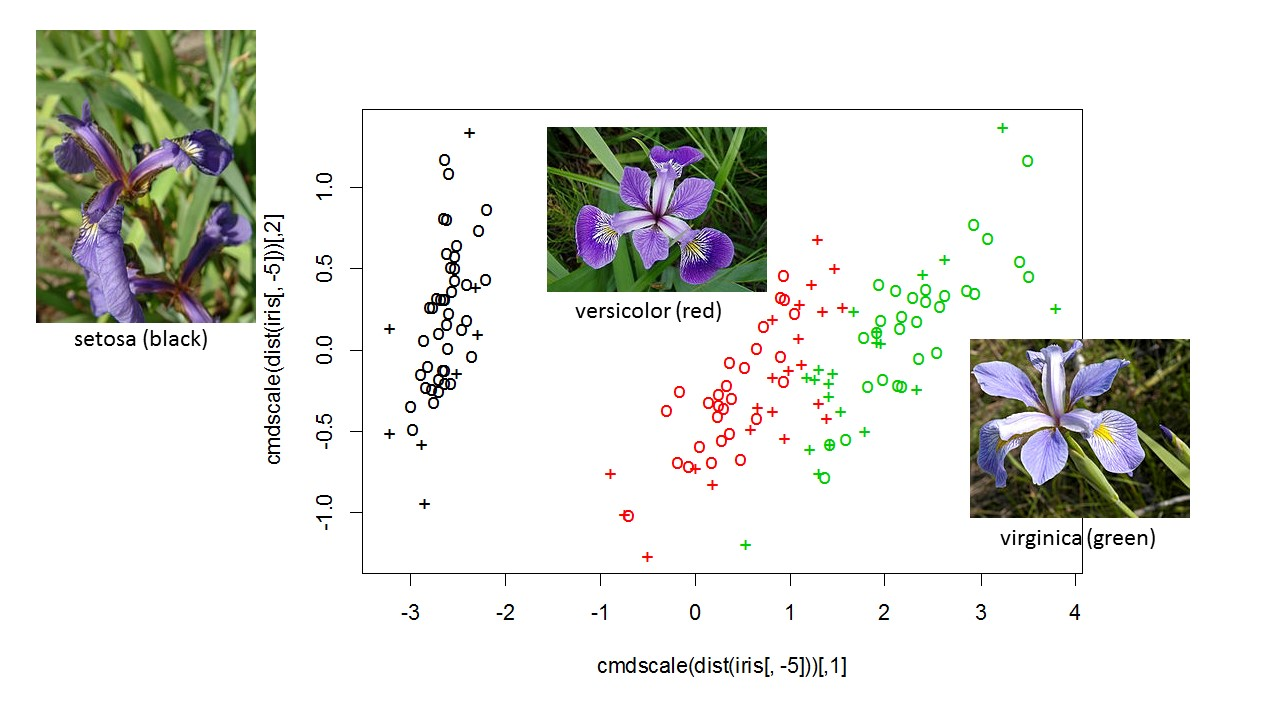

In [ ]:
# Quantum simulator/QPU
#dev = qml.device("lightning.qubit", wires=n_qubits)
#dev = qml.device("default.qubit", wires=4)
#n_shots=1000
n_shots=2000
n_qubits=2
#dev = qml.device("lightning.qubit", wires=tot_qubits)
dev = qml.device('braket.aws.qubit', device_arn='arn:aws:braket:eu-west-2::device/qpu/oqc/Lucy', wires=n_qubits, shots=n_shots)
#dev = qml.device('braket.aws.qubit', device_arn='arn:aws:braket:::device/quantum-simulator/amazon/sv1', wires=n_qubits, shots=n_shots)

State preparation is not as simple as when we represent a bitstring with
a basis state. Every input x has to be translated into a set of angles
which can get fed into a small routine for state preparation. To
simplify things a bit, we will work with data from the positive
subspace, so that we can ignore signs (which would require another
cascade of rotations around the z axis).

Transformation of quantum states using uniformly controlled rotations

The circuit is coded according to the scheme in [Möttönen, et al.
(2004)](https://arxiv.org/abs/quant-ph/0407010), or---as presented for
positive vectors only---in [Schuld and Petruccione
(2018)](https://link.springer.com/book/10.1007/978-3-319-96424-9). We
had to also decompose controlled Y-axis rotations into more basic
circuits following [Nielsen and Chuang
(2010)](http://www.michaelnielsen.org/qcqi/).


In [ ]:
def get_angles(x):

    beta0 = 2 * np.arcsin(np.sqrt(x[1] ** 2) / np.sqrt(x[0] ** 2 + x[1] ** 2 + 1e-12))
    beta1 = 2 * np.arcsin(np.sqrt(x[3] ** 2) / np.sqrt(x[2] ** 2 + x[3] ** 2 + 1e-12))
    beta2 = 2 * np.arcsin(
        np.sqrt(x[2] ** 2 + x[3] ** 2)
        / np.sqrt(x[0] ** 2 + x[1] ** 2 + x[2] ** 2 + x[3] ** 2)
    )

    return np.array([beta2, -beta1 / 2, beta1 / 2, -beta0 / 2, beta0 / 2])


def statepreparation(a):
    qml.RY(a[0], wires=0)

    qml.CNOT(wires=[0, 1])
    qml.RY(a[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[2], wires=1)

    qml.PauliX(wires=0)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[3], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[4], wires=1)
    qml.PauliX(wires=0)

Let's test if this routine actually works.


In [ ]:
x = np.array([0.53896774, 0.79503606, 0.27826503, 0.0], requires_grad=False)
ang = get_angles(x)


@qml.qnode(dev)
def test(angles):

    statepreparation(angles)

    return qml.state()


state = test(ang)

print("x               : ", x)
print("angles          : ", ang)
print("amplitude vector: ", np.real(state))

Note that the `default.qubit` simulator provides a shortcut to
`statepreparation` with the command `qml.StatePrep(x, wires=[0, 1])`.
However, some devices may not support an arbitrary state-preparation
routine.

Since we are working with only 2 qubits now, we need to update the layer
function as well.


In [ ]:
def layer(W):
    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    qml.CNOT(wires=[0, 1])

The variational classifier model and its cost remain essentially the
same, but we have to reload them with the new state preparation and
layer functions.


In [ ]:
@qml.qnode(dev)
def circuit(weights, angles):
    statepreparation(angles)

    for W in weights:
        layer(W)

    return qml.expval(qml.PauliZ(0))


def variational_classifier(weights, bias, angles):
    return circuit(weights, angles) + bias


def cost(weights, bias, features, labels):
    predictions = [variational_classifier(weights, bias, f) for f in features]
    return square_loss(labels, predictions)

Data
====

We then load the Iris data set. There is a bit of preprocessing to do in
order to encode the inputs into the amplitudes of a quantum state. In
the last preprocessing step, we translate the inputs x to rotation
angles using the `get_angles` function we defined above.

::: {.note}
::: {.title}
Note
:::

The Iris dataset can be downloaded
`<a href="https://raw.githubusercontent.com/XanaduAI/qml/master/demonstrations/variational_classifier/data/iris_classes1and2_scaled.txt"
download=parity.txt target="_blank">here</a>`{.interpreted-text
role="html"} and should be placed in the subfolder
`variational_classifer/data`.
:::


In [ ]:
data = np.loadtxt("data/iris_classes1and2_scaled.txt")
X = data[:, 0:2]
print("First X sample (original)  :", X[0])

# pad the vectors to size 2^2 with constant values
padding = 0.3 * np.ones((len(X), 1))
X_pad = np.c_[np.c_[X, padding], np.zeros((len(X), 1))]
print("First X sample (padded)    :", X_pad[0])

# normalize each input
normalization = np.sqrt(np.sum(X_pad ** 2, -1))
X_norm = (X_pad.T / normalization).T
print("First X sample (normalized):", X_norm[0])

# angles for state preparation are new features
features = np.array([get_angles(x) for x in X_norm], requires_grad=False)
print("First features sample      :", features[0])

Y = data[:, -1]

These angles are our new features, which is why we have renamed X to
"features" above. Let's plot the stages of preprocessing and play around
with the dimensions (dim1, dim2). Some of them still separate the
classes well, while others are less informative.

*Note: To run the following code you need the matplotlib library.*


In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(X[:, 0][Y == 1], X[:, 1][Y == 1], c="b", marker="o", edgecolors="k")
plt.scatter(X[:, 0][Y == -1], X[:, 1][Y == -1], c="r", marker="o", edgecolors="k")
plt.title("Original data")
plt.show()

plt.figure()
dim1 = 0
dim2 = 1
plt.scatter(
    X_norm[:, dim1][Y == 1], X_norm[:, dim2][Y == 1], c="b", marker="o", edgecolors="k"
)
plt.scatter(
    X_norm[:, dim1][Y == -1], X_norm[:, dim2][Y == -1], c="r", marker="o", edgecolors="k"
)
plt.title("Padded and normalised data (dims {} and {})".format(dim1, dim2))
plt.show()

plt.figure()
dim1 = 0
dim2 = 3
plt.scatter(
    features[:, dim1][Y == 1], features[:, dim2][Y == 1], c="b", marker="o", edgecolors="k"
)
plt.scatter(
    features[:, dim1][Y == -1], features[:, dim2][Y == -1], c="r", marker="o", edgecolors="k"
)
plt.title("Feature vectors (dims {} and {})".format(dim1, dim2))
plt.show()

This time we want to generalize from the data samples. To monitor the
generalization performance, the data is split into training and
validation set.


In [ ]:
np.random.seed(0)
num_data = len(Y)
num_train = int(0.75 * num_data)
index = np.random.permutation(range(num_data))
feats_train = features[index[:num_train]]
Y_train = Y[index[:num_train]]
feats_val = features[index[num_train:]]
Y_val = Y[index[num_train:]]

# We need these later for plotting
X_train = X[index[:num_train]]
X_val = X[index[num_train:]]

Optimization
============

First we initialize the variables.


In [ ]:
num_qubits = 2
num_layers = 6

weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

Again we optimize the cost. This may take a little patience.


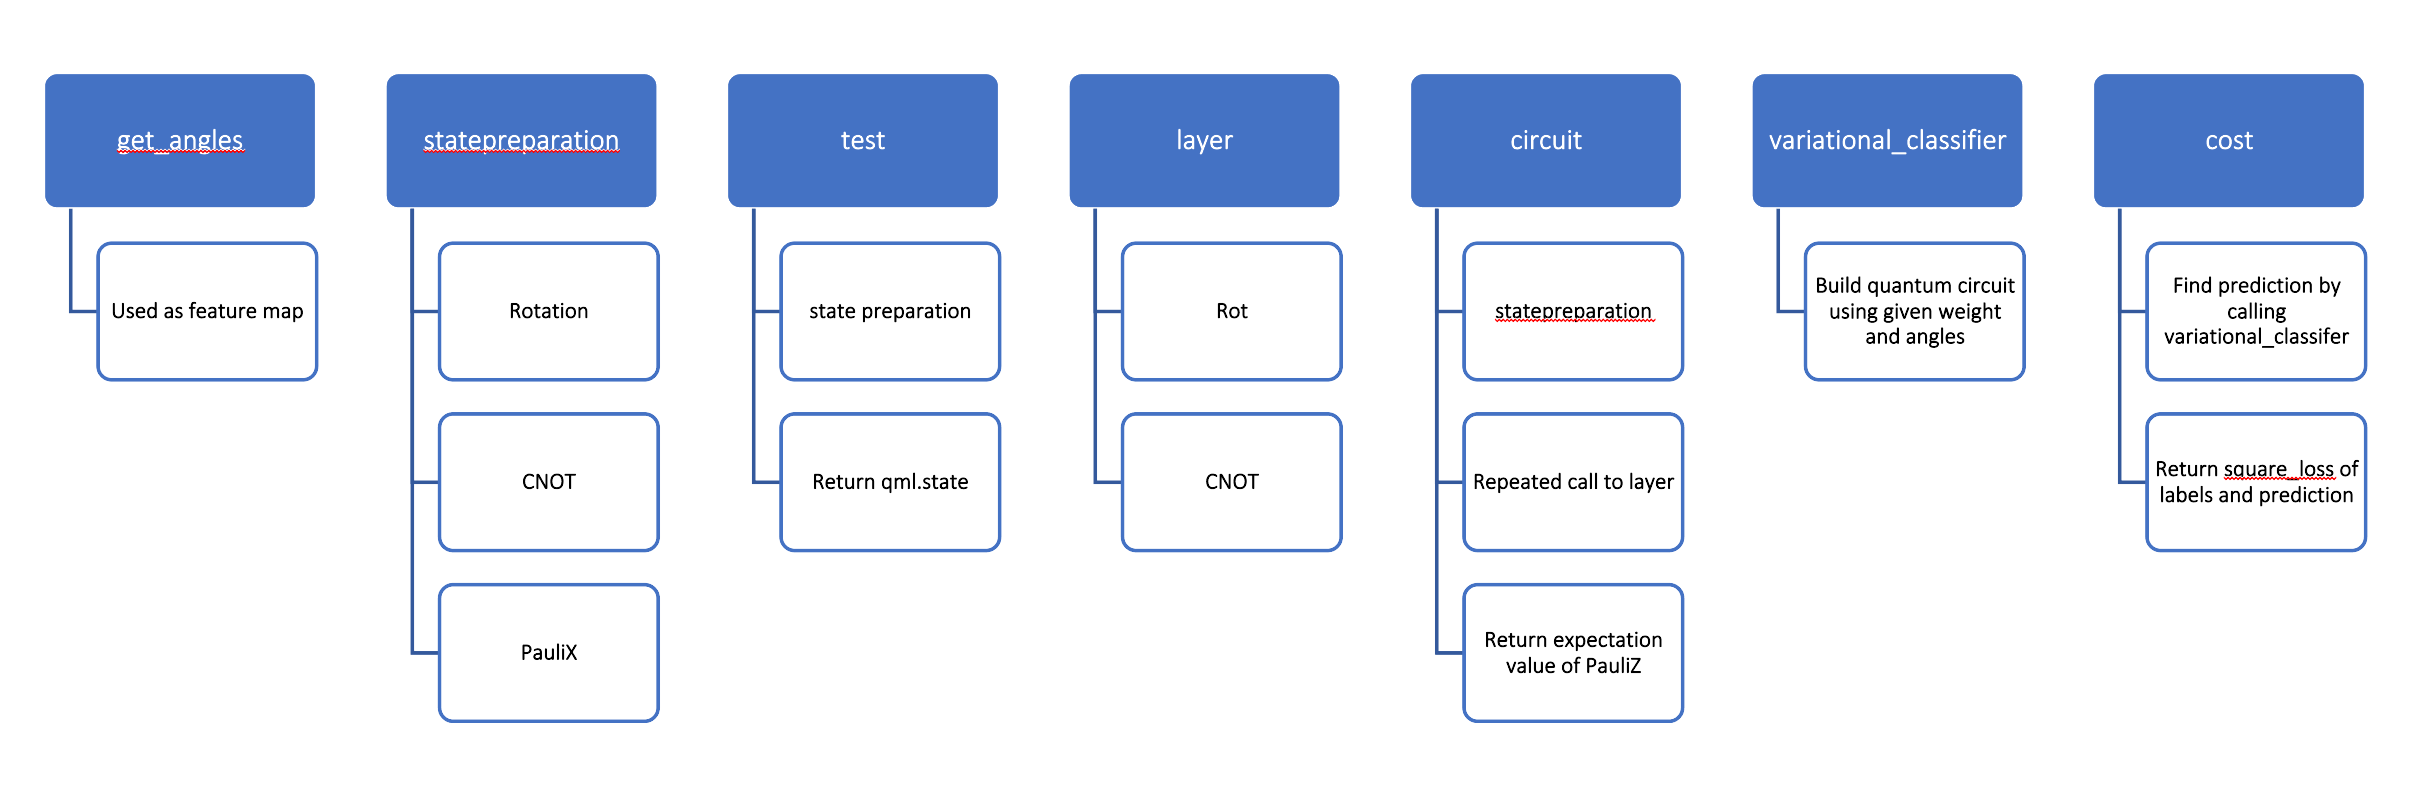

In [ ]:
opt = NesterovMomentumOptimizer(0.01)
batch_size = 5

# train the variational classifier
weights = weights_init
bias = bias_init
for it in range(60):

    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, num_train, (batch_size,))
    feats_train_batch = feats_train[batch_index]
    Y_train_batch = Y_train[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, feats_train_batch, Y_train_batch)

    # Compute predictions on train and validation set
    predictions_train = [np.sign(variational_classifier(weights, bias, f)) for f in feats_train]
    predictions_val = [np.sign(variational_classifier(weights, bias, f)) for f in feats_val]

    # Compute accuracy on train and validation set
    acc_train = accuracy(Y_train, predictions_train)
    acc_val = accuracy(Y_val, predictions_val)

    print(
        "Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f} "
        "".format(it + 1, cost(weights, bias, features, Y), acc_train, acc_val)
    )

We can plot the continuous output of the variational classifier for the
first two dimensions of the Iris data set.


In [ ]:
plt.figure()
cm = plt.cm.RdBu

# make data for decision regions
xx, yy = np.meshgrid(np.linspace(0.0, 1.5, 20), np.linspace(0.0, 1.5, 20))
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]

# preprocess grid points like data inputs above
padding = 0.3 * np.ones((len(X_grid), 1))
X_grid = np.c_[np.c_[X_grid, padding], np.zeros((len(X_grid), 1))]  # pad each input
normalization = np.sqrt(np.sum(X_grid ** 2, -1))
X_grid = (X_grid.T / normalization).T  # normalize each input
features_grid = np.array(
    [get_angles(x) for x in X_grid]
)  # angles for state preparation are new features
predictions_grid = [variational_classifier(weights, bias, f) for f in features_grid]
Z = np.reshape(predictions_grid, xx.shape)

# plot decision regions
cnt = plt.contourf(
    xx, yy, Z, levels=np.arange(-1, 1.1, 0.1), cmap=cm, alpha=0.8, extend="both"
)
plt.contour(
    xx, yy, Z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,)
)
plt.colorbar(cnt, ticks=[-1, 0, 1])

# plot data
plt.scatter(
    X_train[:, 0][Y_train == 1],
    X_train[:, 1][Y_train == 1],
    c="b",
    marker="o",
    edgecolors="k",
    label="class 1 train",
)
plt.scatter(
    X_val[:, 0][Y_val == 1],
    X_val[:, 1][Y_val == 1],
    c="b",
    marker="^",
    edgecolors="k",
    label="class 1 validation",
)
plt.scatter(
    X_train[:, 0][Y_train == -1],
    X_train[:, 1][Y_train == -1],
    c="r",
    marker="o",
    edgecolors="k",
    label="class -1 train",
)
plt.scatter(
    X_val[:, 0][Y_val == -1],
    X_val[:, 1][Y_val == -1],
    c="r",
    marker="^",
    edgecolors="k",
    label="class -1 validation",
)

plt.legend()
plt.show()